<a href="https://colab.research.google.com/github/venkattplethora/MachineLearning/blob/main/BankMarketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Bank Marketing - kNN Example </h1>

The dataset contains the data gathered from a direct marketing campaign for a banking institution. The data represents information about potential bank clients. The classification goal is to predict if the client will subscribe to a term deposit.

<h2 style="background-color:rgba(100,100,100,0.5);"> Frame the problem </h2>

This example uses kNN model, so it is instance based learning (lazy learning).

It is also a classification task, since you are asked to classify whether a client will subscribe or not.

Finally, there is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.

<h2 style="background-color:rgba(100,100,100,0.5);"> Fetch and load data </h2>


Mount google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Read in the csv

In [4]:
import pandas as pd

data_df = pd.read_csv("/content/drive/MyDrive/bank_cleaned.csv")
data_df

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary
0,0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0
1,1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0
3,5,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0
4,6,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40836,45205,25,technician,single,secondary,no,505,no,yes,17,nov,6.43,2,-1,0,unknown,yes,1
40837,45206,51,technician,married,tertiary,no,825,no,no,17,nov,16.28,3,-1,0,unknown,yes,1
40838,45207,71,retired,divorced,primary,no,1729,no,no,17,nov,7.60,2,-1,0,unknown,yes,1
40839,45208,72,retired,married,secondary,no,5715,no,no,17,nov,18.78,5,184,3,success,yes,1


In [5]:
# The data frame also includes the label, so we'll have to separate that.

feature_df = data_df.drop(columns=["response","response_binary"])
feature_label = data_df["response"]

<h2 style="background-color:rgba(100,100,100,0.5);"> Analyze the data and its structure </h2>

In [6]:
print(feature_df.shape)
print(feature_df.head())
print(feature_df.info())
print(feature_df.isnull().sum() / len(data_df) * 100)

(40841, 16)
   Unnamed: 0  age           job  marital  education default  balance housing  \
0           0   58    management  married   tertiary      no     2143     yes   
1           1   44    technician   single  secondary      no       29     yes   
2           2   33  entrepreneur  married  secondary      no        2     yes   
3           5   35    management  married   tertiary      no      231     yes   
4           6   28    management   single   tertiary      no      447     yes   

  loan  day month  duration  campaign  pdays  previous poutcome  
0   no    5   may      4.35         1     -1         0  unknown  
1   no    5   may      2.52         1     -1         0  unknown  
2  yes    5   may      1.27         1     -1         0  unknown  
3   no    5   may      2.32         1     -1         0  unknown  
4  yes    5   may      3.62         1     -1         0  unknown  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40841 entries, 0 to 40840
Data columns (total 16 column

<h3><b>How many instances are there in the dataset</b></h3>

There are 40841 values in the data set, which is large.

<h3><b>Are there missing values (non-null) for any attributes</b></h3>

>Data cleaning will need to be done to address any missing values

None of the parameters have missing values.

<h3><b>What are the numerical and categorical attributes</b></h3>

>Categorical attributes will need to be mapped to numerical values (encoding)

Some of the parameters - job, marital, education are categorical attributes. First, we'll need to see which parameters are irrelevant so we can drop them. The categorical parameters in the relevant ones need to be mapped to numerical values.

<h3><b> Preview the center and dispersion of the features </b></h3>

The above values show the center and dispersion of the features.

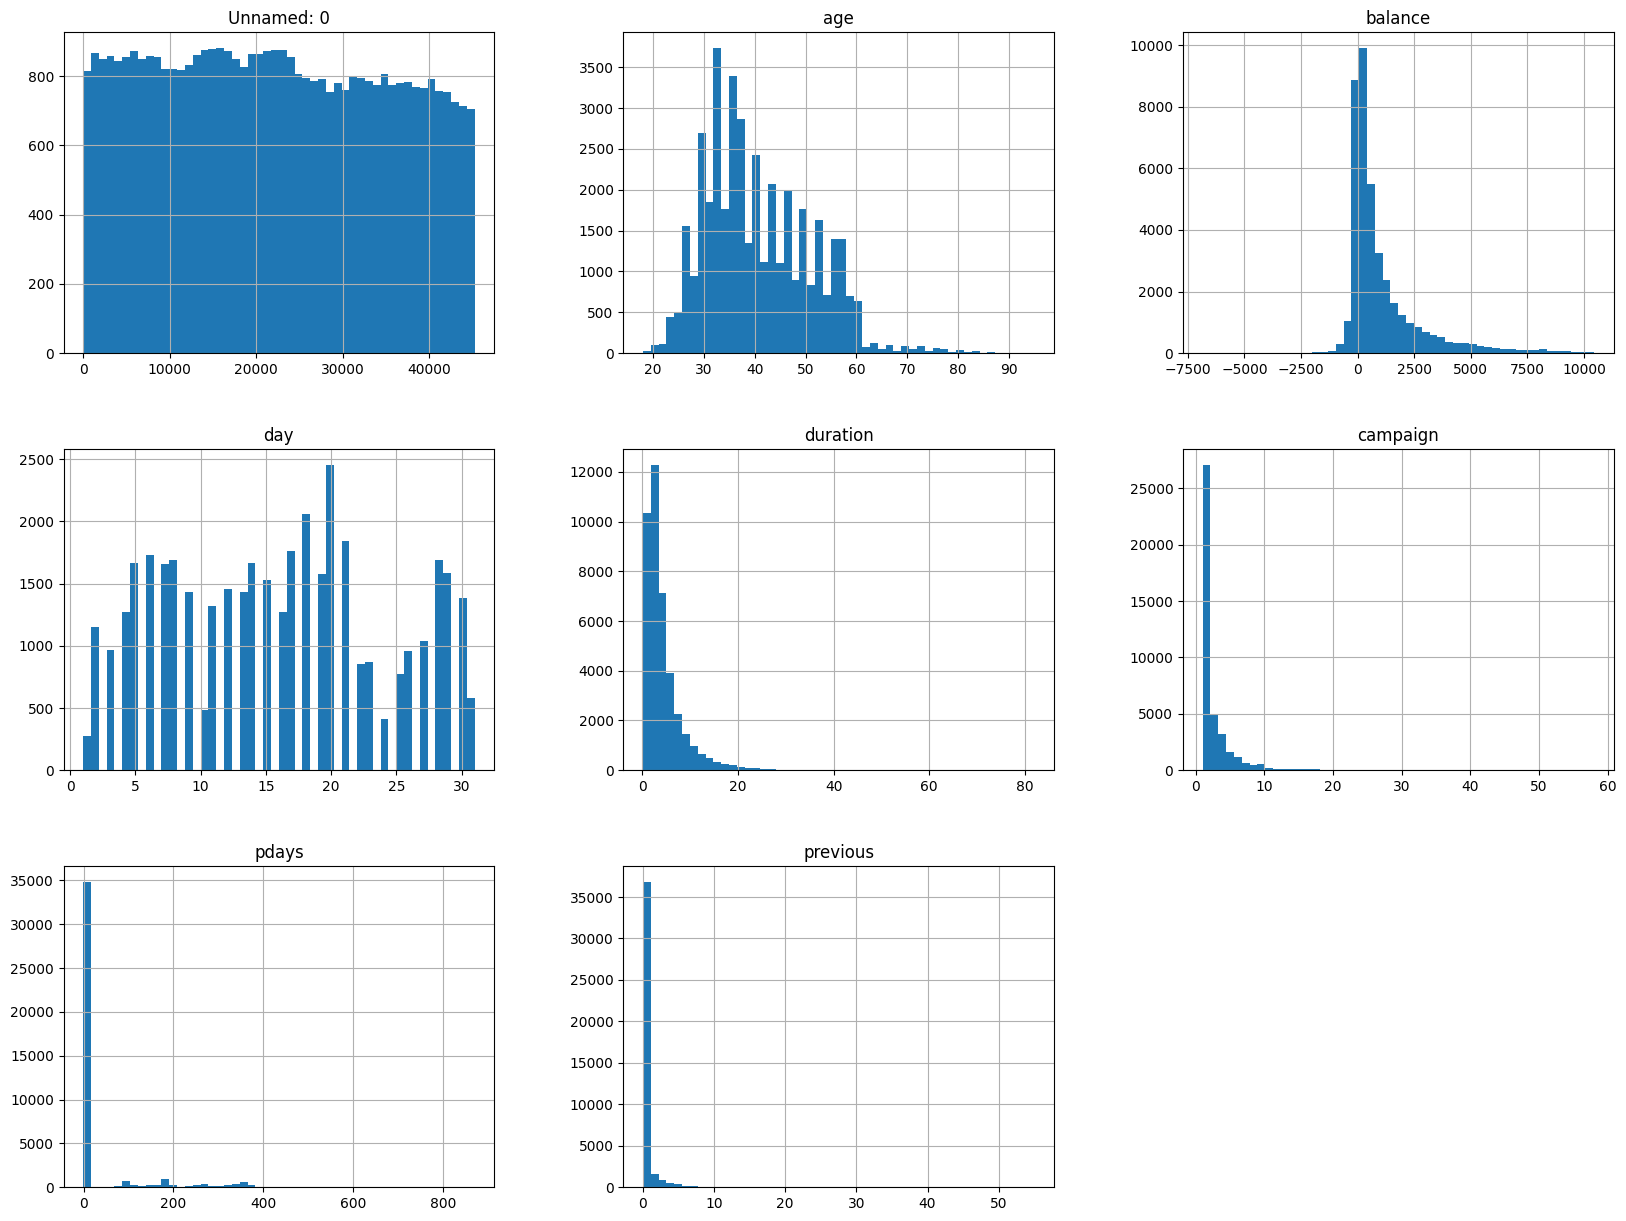

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
feature_df.hist(bins=50, figsize=(20, 15))
plt.show()

<h3><b>Plot the distributions for the features</b></h3>

The three keys to describing the distributions are shape, center, and spread.
Consider clusters, gaps, modes, and outliers.
Look for reasons behind any unusual features.

Shape:
>A few common shapes are symmetric, skewed to the right, skewed to the left, bell-shaped, and uniform distributions. Consider transforming tail-heavy distributions to be more bell-shaped.

Spread:
>Check whether the end values in the range have been capped. For these capped values, either collect actual values to replace the capped values or remove the values from the dataset (The system should not be evaluated poorly if it predicts values beyond the capped values).

>Understand the units for each distribution, whether any scaling has been applied. Consider apply feature scaling for features with different scales (Machine Learning algorithms usually don’t perform well when the input numerical attributes have very different scales).

Some of the distributions seem to be skewed to the left or right, there are no values that seem to be capped. The Unnamed: 0 parameter seems to represent an index, can probably be dropped.

<h2 style="background-color:rgba(100,100,100,0.5);"> Sample the data for testing and training purposes </h2>

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split(), we'll use this with the random_state parameter. Also, since this function can accept multiple datasets with an identical number of rows, and it will split them on the same indices, we can use it to split both the data and target (we'll use stratify on the target so the test and training data will have similar distribution for the target as the original data).

In [33]:
from sklearn.model_selection import train_test_split

X = feature_df
y = feature_label

X_train, X_test, y_train, y_test = train_test_split(feature_df, feature_label, stratify=feature_label, test_size=0.2)

<h2 style="background-color:rgba(100,100,100,0.5);"> Discover and visualize the data to gain insights </h2>

There is no additional value that we can get from attribute transformation, so we can skip this step for this problem.

<h2 style="background-color:rgba(100,100,100,0.5);"> Prepare the Data for Machine Learning Algorithms </h2>

Data cleaning is not required for this data set to clean up missing attributes.

Custom transformation is not needed for this data set.

Feature scaling can be useful to improve the performance of the models.

<h3><b> Data Cleaning - Missing attributes </b></h3>

The parameter *Unnamed: 0* seems irrelevant and can be dropped.

In [34]:
X_train = X_train.drop("Unnamed: 0", axis=1)
X_test = X_test.drop("Unnamed: 0", axis=1)

X_train

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome
5495,28,self-employed,single,tertiary,no,0,yes,no,26,may,26.00,2,-1,0,unknown
12742,51,blue-collar,divorced,secondary,no,104,no,no,9,jul,1.18,1,-1,0,unknown
11741,40,blue-collar,married,secondary,no,-313,yes,no,3,jul,4.18,2,-1,0,unknown
24210,35,self-employed,single,tertiary,no,538,yes,yes,19,nov,5.13,1,195,9,failure
32235,53,management,divorced,secondary,no,28,yes,no,6,may,2.25,2,289,1,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38861,21,student,single,primary,no,423,no,no,18,jan,4.78,5,285,5,success
12917,26,services,married,secondary,no,2063,yes,yes,10,jul,3.68,1,-1,0,unknown
28894,31,management,married,tertiary,no,131,no,no,18,feb,5.53,2,-1,0,unknown
22892,56,management,married,tertiary,no,6798,yes,no,17,nov,4.17,1,-1,0,unknown


<h3><b> Data Cleaning - Handling text and categorical attributes </b></h3>

There are a few attributes that are text/categorical, we will use one hot coding in the single transformer composition later.

<h3><b> Feature Scaling </b></h3>

One of the most important transformations you need to apply to your data is feature scaling.

For this, we will use the scaler directly in the pipeline later to scale these values.

<h3><b> Custom Transformers </b></h3>

Custom transformers are not needed for this data set.

<h3><b> Transformation Pipelines </b></h3>

Scikit-Learn provides the Pipeline class to help with sequences of transformations.

Pipeline for numerical attributes:

In [35]:
# In order to scale numerical attributes, we need to drop categorical ones first.

X_train_num = X_train.drop(columns=["job", "marital", "education", "default", "housing", "loan", "month", "poutcome"], axis=1)
X_train_num

,age,balance,day,duration,campaign,pdays,previous
5495,28,0,26,26.00,2,-1,0
12742,51,104,9,1.18,1,-1,0
11741,40,-313,3,4.18,2,-1,0
24210,35,538,19,5.13,1,195,9
32235,53,28,6,2.25,2,289,1
...,...,...,...,...,...,...,...
38861,21,423,18,4.78,5,285,5
12917,26,2063,10,3.68,1,-1,0
28894,31,131,18,5.53,2,-1,0
22892,56,6798,17,4.17,1,-1,0


In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])

<h3><b> Single Transformer Composition </b></h3>

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(X_train_num)
cat_attribs = ["job", "marital", "education", "default", "housing", "loan", "month", "poutcome"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

X_train_prepared = full_pipeline.fit_transform(X_train)

<h2 style="background-color:rgba(100,100,100,0.5);"> Select and Train Models </h2>

The general approach would be to try out many models and pick the one that works best. But, in this particular case, we specifically want to demonstrate the KNN example, so we will only use that to train and evaluate the performance of the model for different k values.

<h3><b> Training and Evaluating on the Test Set </b></h3>

Let us try different k values and print the accuracy score for each.

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_test_prepared = full_pipeline.fit_transform(X_test)

for nn_neighbors in range(1, 30):
  knn = KNeighborsClassifier(n_neighbors=nn_neighbors)
  knn.fit(X_train_prepared, y_train)
  y_pred = knn.predict(X_test_prepared)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy for kNN with", nn_neighbors, "nearest neighbor is:", round(accuracy * 100, 2))

Accuracy for kNN with 1 nearest neighbor is: 87.71
Accuracy for kNN with 2 nearest neighbor is: 89.57
Accuracy for kNN with 3 nearest neighbor is: 89.63
Accuracy for kNN with 4 nearest neighbor is: 89.89
Accuracy for kNN with 5 nearest neighbor is: 90.17
Accuracy for kNN with 6 nearest neighbor is: 89.86
Accuracy for kNN with 7 nearest neighbor is: 90.01
Accuracy for kNN with 8 nearest neighbor is: 89.96
Accuracy for kNN with 9 nearest neighbor is: 90.04
Accuracy for kNN with 10 nearest neighbor is: 89.89
Accuracy for kNN with 11 nearest neighbor is: 89.8
Accuracy for kNN with 12 nearest neighbor is: 89.83
Accuracy for kNN with 13 nearest neighbor is: 89.91
Accuracy for kNN with 14 nearest neighbor is: 89.89
Accuracy for kNN with 15 nearest neighbor is: 89.89
Accuracy for kNN with 16 nearest neighbor is: 89.96
Accuracy for kNN with 17 nearest neighbor is: 89.85
Accuracy for kNN with 18 nearest neighbor is: 89.79
Accuracy for kNN with 19 nearest neighbor is: 89.83
Accuracy for kNN with 

Let us try different k values, but with cross validation.

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import statistics

X_prepared = full_pipeline.fit_transform(X)

for nn_neighbors in range(1, 30):
  knn = KNeighborsClassifier(n_neighbors=nn_neighbors)
  accuracy = cross_val_score(knn, X_prepared, y, cv=5)
  print("Accuracy for kNN with", nn_neighbors, "nearest neighbor is:", round(statistics.mean(accuracy) * 100, 2))

Accuracy for kNN with 1 nearest neighbor is: 73.82
Accuracy for kNN with 2 nearest neighbor is: 82.77
Accuracy for kNN with 3 nearest neighbor is: 79.26
Accuracy for kNN with 4 nearest neighbor is: 83.5
Accuracy for kNN with 5 nearest neighbor is: 81.65
Accuracy for kNN with 6 nearest neighbor is: 84.1
Accuracy for kNN with 7 nearest neighbor is: 82.99
Accuracy for kNN with 8 nearest neighbor is: 84.63
Accuracy for kNN with 9 nearest neighbor is: 83.87
Accuracy for kNN with 10 nearest neighbor is: 84.98
Accuracy for kNN with 11 nearest neighbor is: 84.32
Accuracy for kNN with 12 nearest neighbor is: 85.28
Accuracy for kNN with 13 nearest neighbor is: 84.79
Accuracy for kNN with 14 nearest neighbor is: 85.56
Accuracy for kNN with 15 nearest neighbor is: 85.1
Accuracy for kNN with 16 nearest neighbor is: 85.82
Accuracy for kNN with 17 nearest neighbor is: 85.44
Accuracy for kNN with 18 nearest neighbor is: 85.99
Accuracy for kNN with 19 nearest neighbor is: 85.71
Accuracy for kNN with 20

Choose a k value that doesn't seem to overfit or underfit the data. Let us choose k=10.

In [40]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_prepared, y_train)

KNeighborsClassifier(n_neighbors=10)